Examine firing rate changes from MAZE to reMAZE to assess the underlying mechanism for reduced place field specficity and reliability during reMAZE in the SD group

### Imports

In [12]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        # plot_dir = Path('/data/Clustering/plots')
        plot_dir = Path('/home/nkinsky/Dropbox (University of Michigan)/Shared_Folders/KD/Manuscripts/SleepDeprivationDrift/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as sstats
import pingouin as pg
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.core.position import Position
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects
from stats_utils import bootstrap_resample, get_bootstrap_prob, get_bootstrap_prob_paired
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()

In [3]:
# Create combined colormap, use cmap3[0::2] to plot dark colors and cmap[1::2] to plot same colors but in light / pastel
cmap1 = sns.color_palette(as_cmap=True)
cmap2 = sns.color_palette("pastel", as_cmap=True)
cmap3 = []
for c1, c2 in zip(cmap1, cmap2):
    cmap3.extend([c1, c2])


### Load in firing rate data

In [4]:
fr_df = pd.read_csv(group_data_dir / "remaze_fr.csv", index_col=0)
fr_df

,neuron_type,neuron_id,nspikes,mean_frate,session_type,delta_frate_maze_remaze,grp,session,nid_unique
0,pyr,0,777,0.211659,MAZE,0.125499,NSD,0,0_0
1,pyr,1,1994,0.543176,MAZE,-0.005908,NSD,0,0_1
2,mua,2,11173,3.043585,MAZE,0.579460,NSD,0,0_2
3,pyr,3,180,0.049033,MAZE,-0.058142,NSD,0,0_3
4,pyr,4,740,0.201580,MAZE,0.084198,NSD,0,0_4
...,...,...,...,...,...,...,...,...,...
2041,pyr,44,6841,1.760422,reMAZE,NaN,SD,8,8_44
2042,pyr,45,369,0.094956,reMAZE,NaN,SD,8,8_45
2043,pyr,46,6436,1.656202,reMAZE,NaN,SD,8,8_46
2044,pyr,47,98,0.025219,reMAZE,NaN,SD,8,8_47


### Load in place field data

In [5]:
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters
sigma2 = 1.5
height_thresh = 0.75
separate_run_dir = True

# Old, combined direction data with different speed and frate thresholds
# grp_savename = subjects.Group.basedir / f"placefield_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}.csv"

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
grp_savename = group_data_dir / f"placefield_grp_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}_{run_flag}.csv"
stats_all_df = pd.read_csv(grp_savename, index_col=0)
stats_all_df["cell_id_unique"] = stats_all_df.apply(lambda row: f"{row.sid}_{row.cell_id}", axis=1)
stats_all_df["cell_id_unique_by_dir"] = stats_all_df.apply(lambda row: f"{row.sid}_{row.cell_id}_{row.direction}", axis=1)
stats_all_df

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,FRmax,FRmax_other_session,direction,session,animal,day,grp,sid,cell_id_unique,cell_id_unique_by_dir
0,7,0,3.0,3.0,45.358242,3.513363,43.486637,NaN,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0,0_7,0_7_up
1,7,1,0.7,0.5,35.953631,2.256332,34.801025,37.057357,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0,0_7,0_7_up
2,7,2,0.5,0.5,3.570236,3.626780,1.742038,5.368818,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0,0_7,0_7_up
3,9,0,0.3,0.3,28.592451,2.961924,27.175557,30.137481,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0,0_9,0_9_up
4,9,1,0.3,0.3,44.586341,5.730577,41.269423,NaN,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0,0_9,0_9_up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204,55,5,1.1,1.1,59.000000,2.262388,57.868831,60.131219,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7,7_55,7_55_down
5205,55,6,0.4,0.4,67.000000,2.974970,65.512044,68.487014,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7,7_55,7_55_down
5206,59,0,0.7,0.7,51.000000,2.395026,49.802487,52.197513,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7,7_59,7_59_down
5207,59,1,0.5,0.5,27.000000,2.793090,25.603455,28.396545,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7,7_59,7_59_down


### Plot mean FR for reMAZE vs MAZE
Sam McKenzie suggestion. Look into Losoczny paper? 

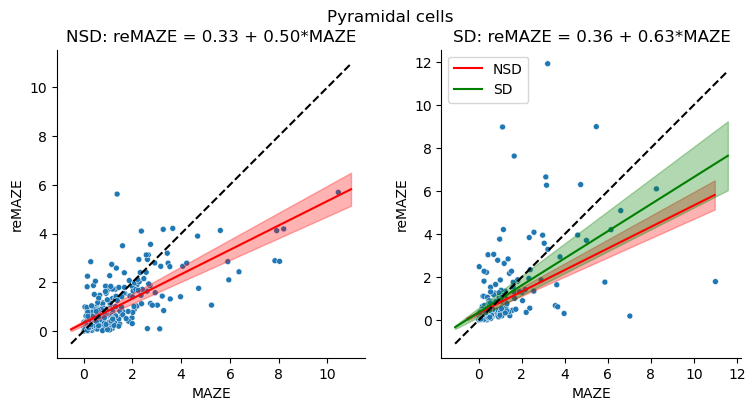

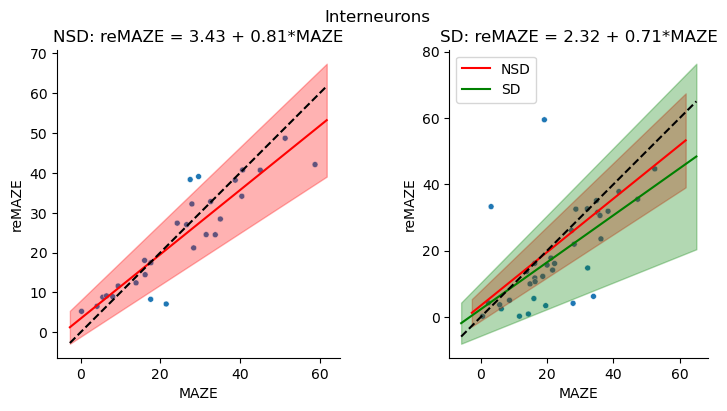

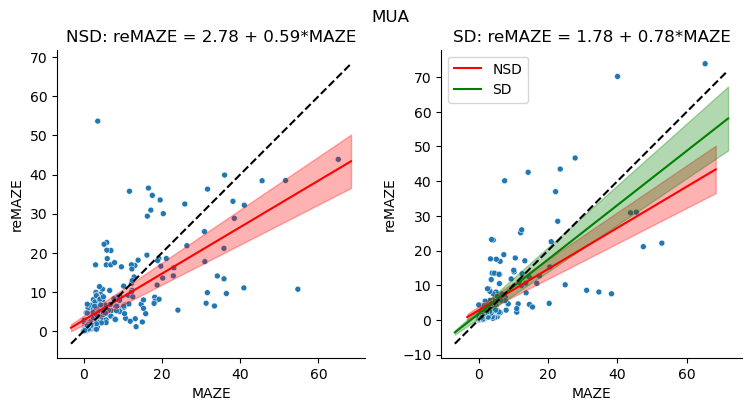

In [6]:
for ntype, nname in zip(["pyr", "inter", "mua"], ["Pyramidal cells", "Interneurons", "MUA"]):
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    fig.suptitle(nname)
    df_type = fr_df[fr_df.neuron_type == ntype]

    xlims_agg = []
    colors = ["r", "g"]
    for ida, (a, grp, color) in enumerate(zip(ax, ["NSD", "SD"], colors)):
        df_use = df_type[df_type.grp == grp]
        df_rs = df_use.pivot(columns="session_type", values="mean_frate", index="nid_unique")
        sns.scatterplot(data=df_rs,x="MAZE", y="reMAZE", size=3, legend=False, ax=a)
        stats = pg.linear_regression(df_rs.MAZE, df_rs.reMAZE)
        if ida == 1:
            a.plot(xlims, xlims * slope + intercept, color=colors[0], label="NSD")
            a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=colors[0], alpha=0.3)
        intercept = stats[stats.names == "Intercept"].coef.values[0]
        slope = stats[stats.names == "MAZE"].coef.values[0]
        a.set_aspect('equal')
        xlims = np.array(a.get_xlim())
        # xlims = np.array(a.get_xlim()) if ida == 0 else xlims
        a.plot(xlims, xlims * slope + intercept, color, label="SD")
        intb = stats[stats.names == "Intercept"]["CI[2.5%]"].values[0]
        intt = stats[stats.names == "Intercept"]["CI[97.5%]"].values[0]
        mb = stats[stats.names == "MAZE"]["CI[2.5%]"].values[0]
        mt = stats[stats.names == "MAZE"]["CI[97.5%]"].values[0]
        a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=color, alpha=0.3)
        a.plot(xlims, xlims, 'k--')
        # a.set_xlim(xlims)
        # a.set_ylim(xlims)
        a.set_title(f"{grp}: reMAZE = {intercept:0.2f} + {slope:0.2f}*MAZE")
        if ida == 1:
            a.legend()
    sns.despine(fig=fig)
    fig.savefig(plot_dir / f"reMAZE_v_MAZE_meanFR_{ntype}.pdf")

### Plot Peak FR for reMAZE vs. MAZE

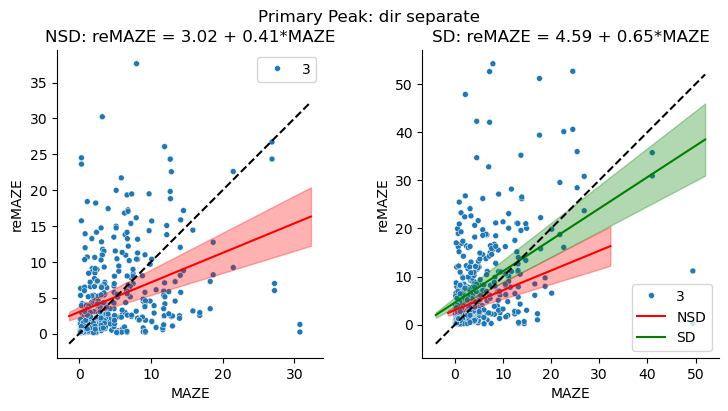

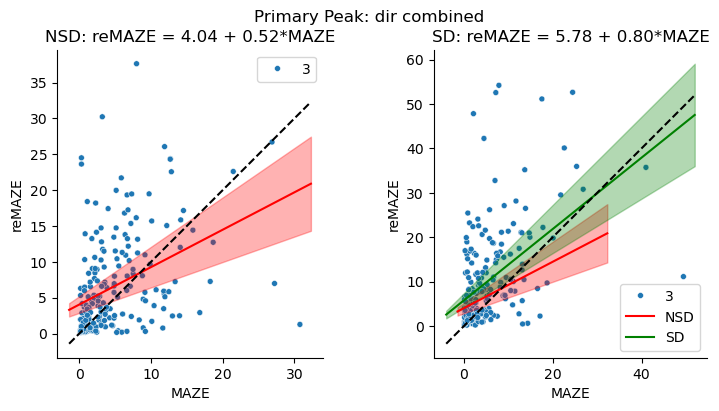

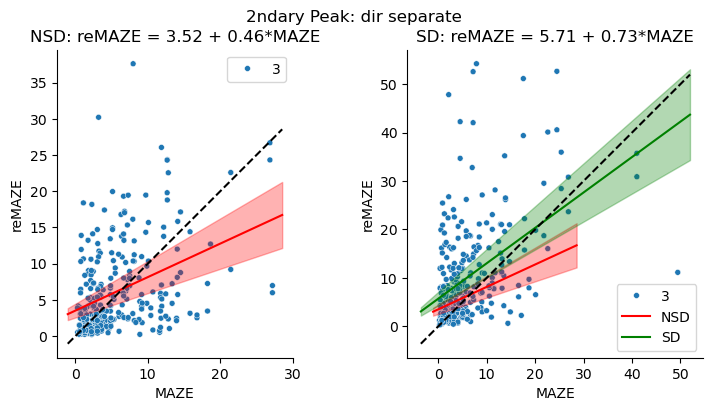

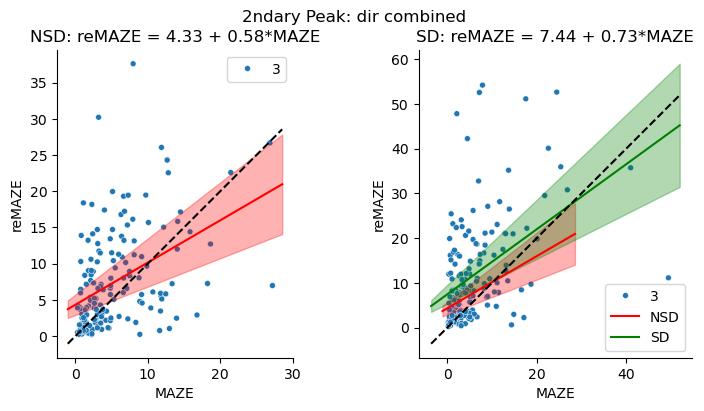

In [7]:
# direction = "separate" # "combined"
for peak in [0, 1]:
    assert peak in [0, 1]
    peak_type = "Primary" if peak == 0 else "2ndary"
    for direction in ["separate", "combined"]:
        assert direction in ["combined", "separate"]
        index_use = "cell_id_unique" if direction == "combined" else "cell_id_unique_by_dir"
        fig, ax = plt.subplots(1, 2, figsize=(9, 4))
        fig.suptitle(f"{peak_type} Peak: dir {direction}")
        for ida, (a, grp, color) in enumerate(zip(ax, ["NSD", "SD"], colors)):
            df_peak = stats_all_df[stats_all_df.peak_no == peak]
            df_use = df_peak[df_peak.grp == grp]
            if direction == "combined":
                df_use = df_use.groupby(["cell_id_unique", "session"]).max().reset_index()
            df_rs = df_use.pivot(columns="session", values="FRmax", index=index_use)
            sns.scatterplot(data=df_rs,x="MAZE", y="reMAZE", size=3, ax=a)
            df_rs_clean = df_rs[~np.any(np.isnan(df_rs.values), axis=1)]
            stats = pg.linear_regression(df_rs_clean.MAZE, df_rs_clean.reMAZE)
            if ida == 1:
                a.plot(xlims, xlims * slope + intercept, color=colors[0], label="NSD")
                a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=colors[0], alpha=0.3)
            intercept = stats[stats.names == "Intercept"].coef.values[0]
            slope = stats[stats.names == "MAZE"].coef.values[0]
            a.set_aspect('equal')
            xlims = np.array(a.get_xlim())
            # xlims = np.array(a.get_xlim()) if ida == 0 else xlims
            a.plot(xlims, xlims * slope + intercept, color, label="SD")
            intb = stats[stats.names == "Intercept"]["CI[2.5%]"].values[0]
            intt = stats[stats.names == "Intercept"]["CI[97.5%]"].values[0]
            mb = stats[stats.names == "MAZE"]["CI[2.5%]"].values[0]
            mt = stats[stats.names == "MAZE"]["CI[97.5%]"].values[0]
            a.fill_between(xlims, xlims * mb + intb, xlims * mt + intt, color=color, alpha=0.3)
            # a.set_xlim(xlims)
            # a.set_ylim(xlims)
            a.plot(xlims, xlims, 'k--')
            if ida == 1:
                a.legend()
            a.set_title(f"{grp}: reMAZE = {intercept:0.2f} + {slope:0.2f}*MAZE")
        sns.despine(fig=fig)
        fig.savefig(plot_dir / f"reMAZE_v_MAZE_PFpeakFR_dir_{direction}_{ntype}.pdf")

### Plot mean firing rate changes

In [22]:
df_bs = pd.read_csv(group_data_dir / "remaze_fr_bootstrap.csv", index_col=0)
df_bs

,grp,session,mean_frate,neuron_type
0,NSD,MAZE,1.091980,pyr
1,NSD,MAZE,1.304717,pyr
2,NSD,MAZE,1.095490,pyr
3,NSD,MAZE,1.062064,pyr
4,NSD,MAZE,0.940262,pyr
...,...,...,...,...
19995,SD,reMAZE,8.871773,mua
19996,SD,reMAZE,5.697908,mua
19997,SD,reMAZE,8.239004,mua
19998,SD,reMAZE,7.535709,mua


In [17]:
df2_mean

,grp,session_type,sid,neuron_id,nspikes,mean_frate,delta_frate_maze_remaze
0,NSD,MAZE,0,67.675325,3310.363636,0.901761,0.030103
1,NSD,MAZE,1,137.582781,4322.218543,1.305806,0.334436
2,NSD,MAZE,2,46.270270,3149.972973,1.008314,0.304389
3,NSD,MAZE,3,41.564103,4099.641026,1.274368,0.329547
4,NSD,reMAZE,0,67.675325,2903.493506,0.871658,NaN
5,NSD,reMAZE,1,137.582781,3087.986755,0.971370,NaN
6,NSD,reMAZE,2,46.270270,2226.513514,0.703925,NaN
7,NSD,reMAZE,3,41.564103,2287.410256,0.944820,NaN
8,SD,MAZE,4,54.209302,3133.255814,0.783706,0.358616
9,SD,MAZE,5,37.428571,4413.000000,1.332830,-0.716111


/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:384: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:395: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:436: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:8.200e-03 Stat=2.459e-01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:4.422e-01 Stat=-8.432e-04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:1.395e-01 Stat=1.378e+00


/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:384: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:395: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:436: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:1.920e-02 Stat=4.452e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:1.553e-01 Stat=6.967e-01


/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:384: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:395: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:436: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       #: 2.50e-02 < p <= 5.00e-02
       *: 5.00e-03 < p <= 2.50e-02
      **: 5.00e-04 < p <= 5.00e-03
     ***: p <= 5.00e-04

MAZE vs. reMAZE: get_bootstrap_prob_paired, P_val:4.079e-01 Stat=-2.653e-01


/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:384: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:395: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(
/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/plotters.py:436: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.plot_kw["ax"].set_xticklabels(xlabels,


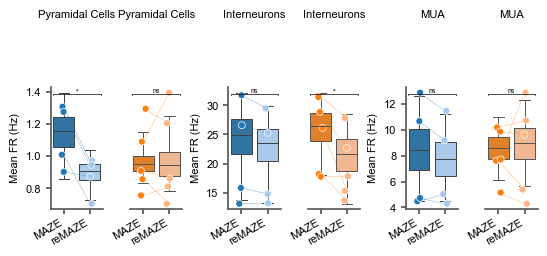

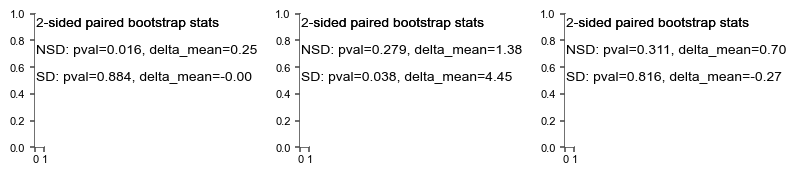

In [26]:
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired
fig = Fig(16, 12)
figs = Fig(16, 12)

results_list = []
for ida, (ntype, nname) in enumerate(zip(["pyr", "inter", "mua"], ["Pyramidal Cells", "Interneurons", "MUA"])):
    df2 = df_bs[df_bs.neuron_type == ntype]
    df2_mean = fr_df[fr_df.neuron_type == ntype].groupby(["grp", "session_type", "session"]).mean(numeric_only=True).reset_index()
    df2_mean = df2_mean.rename(columns={"session": "sid", "session_type": "session"})

    for idg, grp in enumerate(["NSD", "SD"]):
        ax = fig.subplot(fig.gs[0:2, ida * 2 + idg])
        axstat = figs.subplot(figs.gs[2:4, ida * 2])
        
        # sns.boxplot(data=df2, x="grp", y="mean_frate", hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, ax=ax)
        # sns.stripplot(data=df2_mean, x="grp", y="mean_frate", hue="session_type", dodge=True, edgecolor="w", linewidth=0.5, ax=ax)
        p1 = Plotter(data=df2[df2.grp == grp], x="session", y="mean_frate", ax=ax)
        results_list.append(p1.boxplot_remaze(palette=cmap3[idg*2:(idg+1)*2], zorder=3, sep=1.2).stat_anot_remaze(
                    stat_within=get_bootstrap_prob_paired,
                    alpha_within=[0.025, 0.005, 0.0005],
                    alpha_trend=0.05,
                    fontsize=5,
                    verbose=True,
                    prepend=("reliability", grp),
                ))
        p2 = Plotter(data=df2_mean[df2_mean.grp == grp], x="session", y="mean_frate", ax=ax)
        p2.striplineplot_remaze(palette=cmap3[idg*2:(idg+1)*2], grp_offset=0, dodge=0, units="sid")
        ax.set_title(nname)
        ax.set_ylabel("Mean FR (Hz)")
        ax.set_xlabel("")
    
        axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
        if idg == 0:
            sns.despine(ax=ax)
        else:
            sns.despine(ax=ax, left=True)
            ax.set_ylabel("")
            ax.set_yticks([])
    yt = 0.7
    for grp in ["NSD", "SD"]:
        df_grp = df2[df2.grp == grp]
        dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"].mean_frate, df_grp[df_grp.session == "reMAZE"].mean_frate)
        axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
        yt -= 0.2
    sns.despine(ax=axstat, left=True, bottom=True)
    axstat.set_xticks([])
    axstat.set_yticks([])

fig.savefig(plot_dir / "MeanFR_bootstrap.pdf")
figs.savefig(plot_dir / "MeanFR_bootstrap_stats.pdf")

In [71]:
sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
                    fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"])

KstestResult(statistic=0.2777777777777778, pvalue=0.12469435207968083, statistic_location=16.160163624921335, statistic_sign=-1)

In [63]:
fr_use = fr_df[fr_df.neuron_type == ntype]
tstats = pg.ttest(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
             fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"],
             paired=True).iloc[0]
print(f"{grp}: p={tstats['p-val']:0.3f}, T={tstats['T']}, dof={tstats['dof']}")

SD: p=0.036, T=2.1756778958787857, dof=35


In [70]:
sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"],
                        fr_use[(fr_use.grp == "NSD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"])

KstestResult(statistic=0.373015873015873, pvalue=0.01808873762303772, statistic_location=2.638276206487248, statistic_sign=-1)

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_42069/3607308767.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], y="delta_frate_maze_remaze", hue="grp", dodge=True, palette=cmap3[::2],
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_42069/3607308767.py:24: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], y="delta_frate_maze_remaze", hue="grp", dodge=True, palette=cmap3[::2],


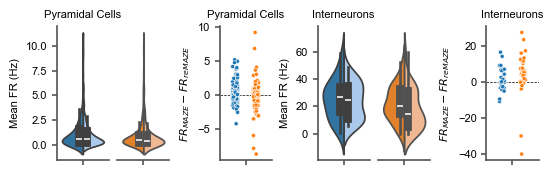

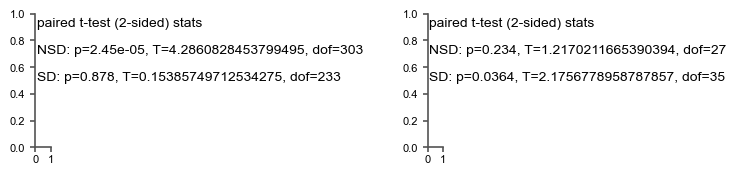

In [73]:
fig = Fig(16, 12)
figs = Fig(16, 12)

for idn, (ntype, nname) in enumerate(zip(["pyr", "inter"], ["Pyramidal Cells", "Interneurons"])):

    axstat = figs.subplot(figs.gs[2:4, idn * 3])
    # sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", dodge=True, ax=ax[0])
    # # sns.lineplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", units="unique_nid", estimator=None, ax=ax[0])
    fr_ntype = fr_df[fr_df.neuron_type == ntype]
    for idg, grp in enumerate(["NSD", "SD"]):
        ax = fig.subplot(fig.gs[0:2, idn * 3 + idg])
        sns.violinplot(data=fr_ntype[fr_ntype.grp == grp], y="mean_frate", hue="session_type", palette=cmap3[idg*2:(idg+1)*2],
                       split=True, legend=False, ax=ax)
        if idg == 0:
            sns.despine(ax=ax)
            ax.set_ylabel("Mean FR (Hz)")
            ax.set_title(nname)
        else:
            sns.despine(ax=ax, left=True)
            ax.set_ylabel("")
            ax.set_yticks([])
    
    ax2 = fig.subplot(fig.gs[0:2, idn * 3 + 2])
    sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], y="delta_frate_maze_remaze", hue="grp", dodge=True, palette=cmap3[::2], 
                  ax=ax2, size=3, edgecolor="w", linewidth=0.4, legend=False)
    ax2.axhline(0, color="k", linestyle="--", linewidth=0.5)
    ax2.set_ylabel(r"$FR_{MAZE} - FR_{reMAZE}$")
    ax2.set_xlabel("")
    ax2.set_title(nname)

    sns.despine(ax=ax2)

    # Run stats
    axstat.text(0.1, 0.9, "paired t-test (2-sided) stats")
    idy = 0.7
    for grp in ["NSD", "SD"]:
        fr_use = fr_df[fr_df.neuron_type == ntype]
     
        tstats = pg.ttest(fr_use[(fr_use.grp == grp) & (fr_use.session_type == "MAZE")]["mean_frate"],
                 fr_use[(fr_use.grp == grp) & (fr_use.session_type == "reMAZE")]["mean_frate"],
                 paired=True).iloc[0]
        axstat.text(0.1, idy, f"{grp}: p={tstats['p-val']:0.3g}, T={tstats['T']}, dof={tstats['dof']}")
        idy -= 0.2
        
        # sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
        #                 fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"])
        
        # Distribution of interneuron firing rates is different between groups as well (stable neurons only, doesn't hold if we include all)
        # stats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"],
        #                 fr_use[(fr_use.grp == "NSD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"])

    
fig.savefig(plot_dir / f"FR_delta_comprehensive.pdf")

In [19]:
df_bs = pd.read_csv(group_data_dir / "remaze_fr_delta_bootstrap.csv", index_col=0)

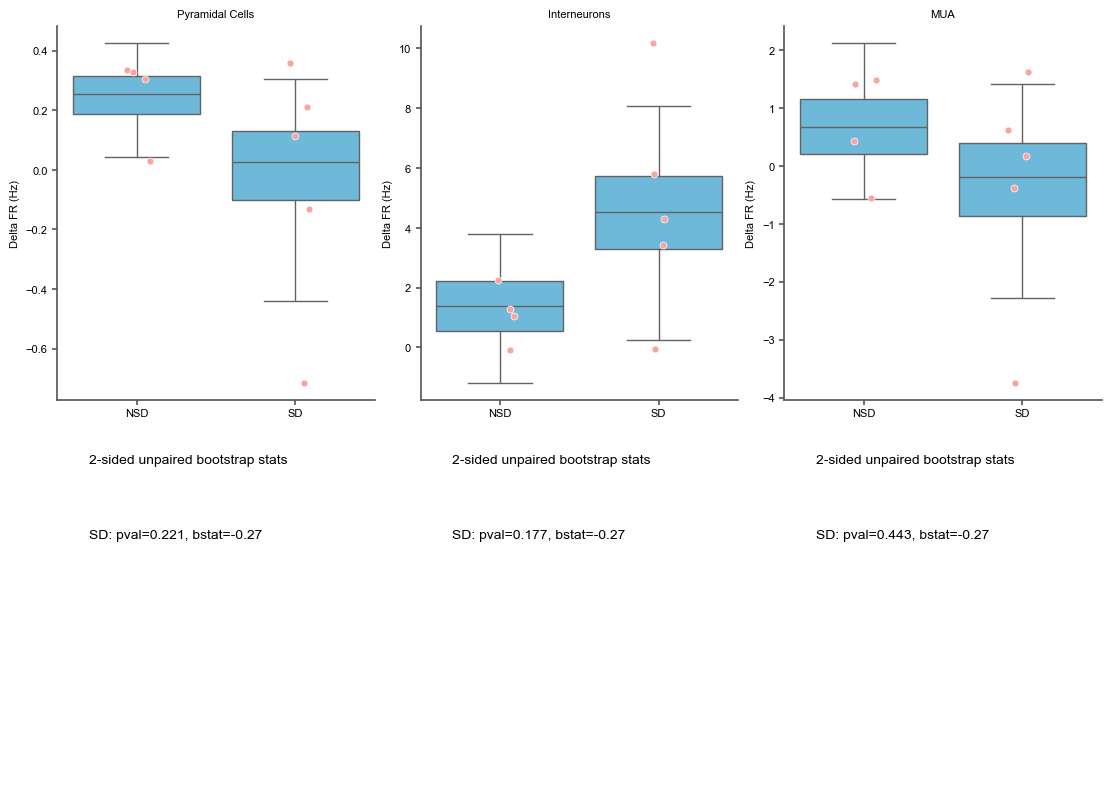

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(11, 8))
for ax, axstat, ntype, nname in zip(axs[0], axs[1], ["pyr", "inter", "mua"], ["Pyramidal Cells", "Interneurons", "MUA"]):
    df2 = df_bs[df_bs.neuron_type == ntype]
    df2_mean = fr_df[fr_df.neuron_type == ntype].groupby(["grp", "session_type", "session"]).mean(numeric_only=True)
    sns.boxplot(data=df2, x="grp", y="delta_frate", whis=(2.5, 97.5), showfliers=False, legend=False, ax=ax)
    sns.stripplot(data=df2_mean, x="grp", y="delta_frate_maze_remaze", edgecolor="w", linewidth=0.5, ax=ax)
    ax.set_title(nname)
    ax.set_ylabel("Delta FR (Hz)")
    ax.set_xlabel("")
    sns.despine(ax=ax)

    axstat.text(0.1, 0.9, "2-sided unpaired bootstrap stats") 
    yt = 0.7
    bstat, pval = get_bootstrap_prob(df2[df2.grp == "NSD"].delta_frate, df2[df2.grp == "SD"].delta_frate)
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, bstat={dmean:0.2f}")
    
    sns.despine(ax=axstat, left=True, bottom=True)
    axstat.set_xticks([])
    axstat.set_yticks([])

fig.savefig(plot_dir / "MeanFR_bootstrap_bw_groups.pdf")

### Plot max firing rates using time based (not place field based) analysis
Do I need to smooth before I do this?

In [ ]:
neuron_type = "stable" # "stable" # 'all' or 'stable'
time_bin = 2 # in seconds
fr_max_df = []
for ids, sess in enumerate(sessions):
    assert neuron_type in ("all", "stable")
    neurons_use = sess.neurons if neuron_type == "all" else sess.neurons_stable
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    fr_max_temp = []
    for times, sesh_type in zip([maze, remaze], ["MAZE", "reMAZE"]):
        binned = neurons_use.time_slice(*times).get_binned_spiketrains(bin_size=time_bin)
        max_fr = binned.firing_rate.max(axis=1)
        fr_temp = pd.DataFrame({"cell_id": binned.neuron_ids, "neuron_type": neurons_use.neuron_type, "FRmax (time)": max_fr})
        fr_temp["session_type"] = sesh_type
        fr_max_temp.append(fr_temp)
    
    fr_max_temp = pd.concat(fr_max_temp, axis=0)

    fr_max_temp["bin size (sec)"] = time_bin
    fr_max_temp["animal"] = sess.animal.name
    fr_max_temp["day"] = sess.animal.day
    fr_max_temp["grp"] = sess.tag
    fr_max_temp["sid"] = ids

    fr_max_df.append(fr_max_temp)

fr_max_df = pd.concat(fr_max_df, axis=0)

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(9, 4))

df_max_mean = fr_max_df.groupby(["grp", "sid", "neuron_type", "session_type"]).mean(numeric_only=True).reset_index()

for a, ntype in zip(ax, ["pyr", "inter", "mua"]):
    df_use = df_max_mean[df_max_mean.neuron_type == ntype]

    legend = True if ntype == "mua" else False
    sns.stripplot(data=df_use, x="grp", y="FRmax (time)", hue="session_type", dodge=True, legend=legend, ax=a)
    a.set_title(ntype)



In [ ]:
ntype = "inter"
df_use = df_max_mean[df_max_mean.neuron_type == ntype]
df_use

In [ ]:
ntype = "pyr"
df_use = df_max_mean[df_max_mean.neuron_type == ntype]
df_use